In [1]:
!pip3 install matplotlib

In [2]:
!pip3 install pinotdb

In [4]:
!pip3 install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 9.7 MB/s eta 0:00:00 0:00:01


#### CODE

In [21]:
from pinotdb import connect
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [22]:
# config

NUM_REQUESTS = 200  # Number of concurrent requests
NUM_THREADS = 8  # Number of concurrent threads
QUERY = [
    # Simple SELECT with filtering (WHERE clause)
    """
    SELECT 
    company_id,
      status_code,
      courier
    FROM shipments
    WHERE courier = 'Blue Dart Air' AND status_code = 'NEW';
    """,
    
    # Simple SELECT
    """
    SELECT 
      id, 
      order_id, 
      status 
    FROM 
      shipments;
    """,
    
    # Simple SELECT with ordering on a date field
    """
    SELECT 
      id, 
      order_id, 
      shipped_date, 
      delivered_date 
    FROM 
      shipments
    WHERE 
      delivered_date IS NOT NULL
	  AND shipped_date IS NOT NULL
    ORDER BY 
      delivered_date DESC;
    """,
    
    # Aggregation query
    """
    SELECT 
      courier, 
      COUNT(id) AS shipment_count 
    FROM 
      shipments 
	WHERE 
	  courier is not null
    GROUP BY 
      courier
    ORDER BY 
      shipment_count DESC;
    """,
    
    # Count and sums
    """
    SELECT 
      COUNT(id) AS total_shipments
    FROM 
      shipments
    WHERE 
      status = 1 
      AND created_at BETWEEN '2024-11-15T12:24:36Z' AND '2024-11-15T15:52:53Z';
    """
]

In [26]:
def run_query(QUERY, i):
    """ Runs a query against the Pinot real-time data and returns the compute time """
    try:
        # Update the Pinot connection to use port 8099
        conn = connect(host='localhost', port=8099, path='/query/sql', scheme='http')
        curs = conn.cursor()
        
        # Logging time for query compute and response
        start_time = time.time()
        curs.execute(QUERY[i])
        rows = curs.fetchall()
        cols = [field[0] for field in curs.description]
        df = pd.DataFrame(rows, columns=cols)
        end_time = time.time()

        # Check if result has 0 rows
        if df.empty:
            return 0
        else:
            return end_time - start_time
    except Exception as e:
        print(f"Error: {e}")
        return None

In [27]:
def benchmark():
    """ Benchmarks query results on a plot for real-time Pinot data """
    try:
        print("\nStarting Benchmarking...")
        print(f"NUMBER OF THREADS: {NUM_THREADS}")
        print(f"DATASET SIZE: Real-time data\n")

        # Iterate through queries to benchmark each one
        for i in range(len(QUERY)):
            response_times = []
            
            print(f"Running benchmark for Query {i + 1}:")
            print(QUERY[i])
            print("-" * 80)

            # Running executors asynchronously for concurrent requests
            with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
                futures = [executor.submit(run_query, QUERY, i) for _ in range(NUM_REQUESTS)]
                for future in as_completed(futures):
                    response_time = future.result()
                    if response_time is not None:
                        response_times.append(response_time)
            
            # Check if any responses were recorded
            if response_times:
                # Plotting the results
                plt.figure(figsize=(13, 4))
                plt.plot(response_times, marker='o', linestyle='-', color='b')
                plt.xlabel('Request Number')
                plt.ylabel('Response Time (seconds)')
                plt.title(f'Response Time for Query {i + 1}')
                plt.grid(True)
                plt.show()

                # Display average response time
                avg_time = sum(response_times) / len(response_times)
                print(f"Average Response Time for Query {i + 1}: {avg_time:.2f} seconds\n")
            else:
                print(f"No valid responses for Query {i + 1}\n")
            
            print("=" * 80)
            
    except Exception as e:
        print(f"Error during benchmarking: {e}")


Starting Benchmarking...
NUMBER OF THREADS: 8
DATASET SIZE: Real-time data

Running benchmark for Query 1:

    SELECT company_id,
  status_code,
  courier
FROM shipments
WHERE courier = 'Blue Dart Air' AND status_code = 'NEW';
    
--------------------------------------------------------------------------------


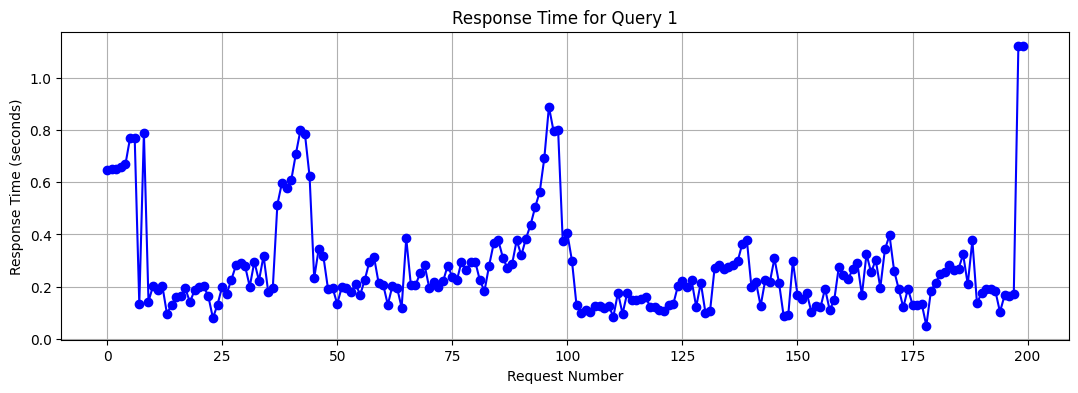

Average Response Time for Query 1: 0.27 seconds

Running benchmark for Query 2:

    SELECT 
      id, 
      order_id, 
      status 
    FROM 
      shipments;
    
--------------------------------------------------------------------------------


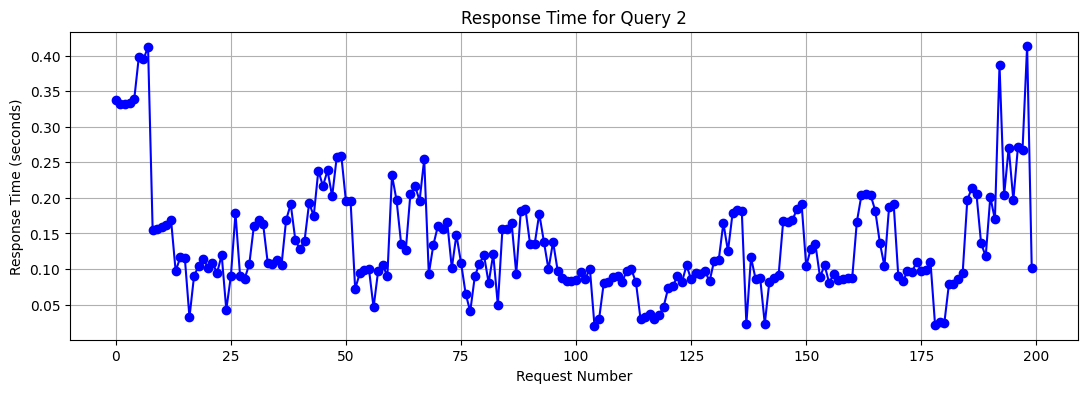

Average Response Time for Query 2: 0.14 seconds

Running benchmark for Query 3:

    SELECT 
      id, 
      order_id, 
      shipped_date, 
      delivered_date 
    FROM 
      shipments
    WHERE 
      delivered_date IS NOT NULL
	  AND shipped_date IS NOT NULL
    ORDER BY 
      delivered_date DESC;
    
--------------------------------------------------------------------------------


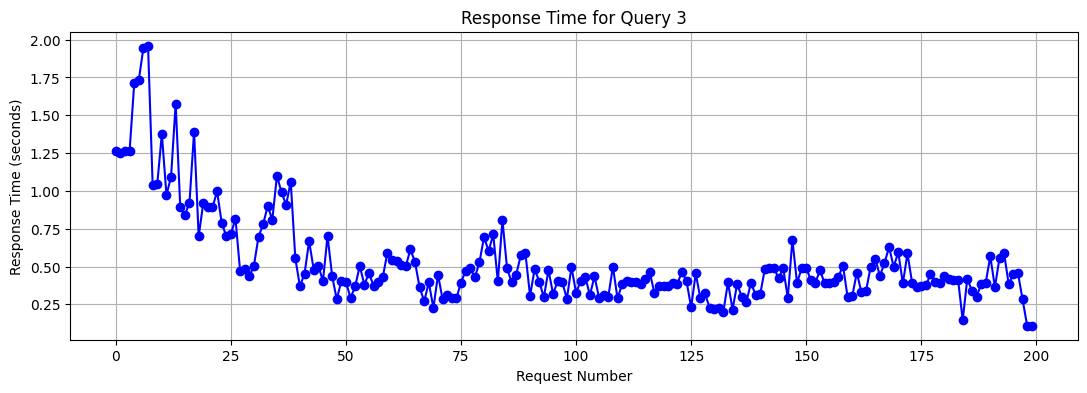

Average Response Time for Query 3: 0.53 seconds

Running benchmark for Query 4:

    SELECT 
      courier, 
      COUNT(id) AS shipment_count 
    FROM 
      shipments 
	WHERE 
	  courier is not null
    GROUP BY 
      courier
    ORDER BY 
      shipment_count DESC;
    
--------------------------------------------------------------------------------


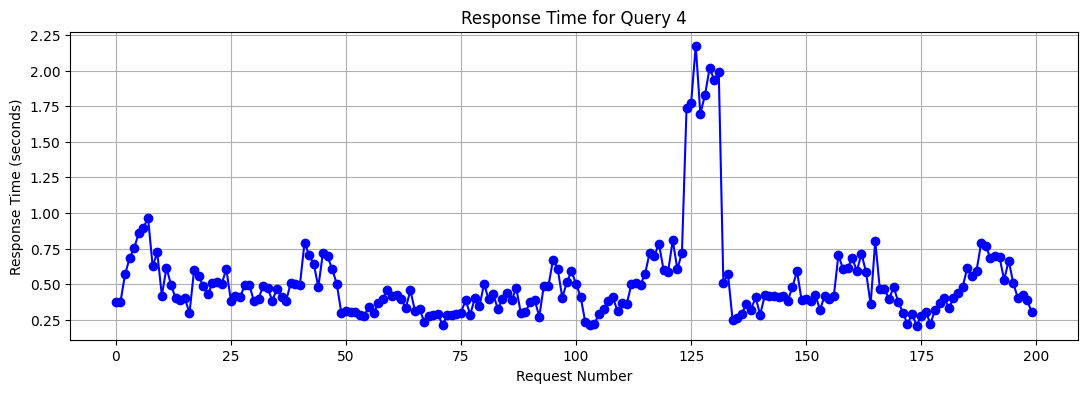

Average Response Time for Query 4: 0.51 seconds

Running benchmark for Query 5:

    SELECT 
      COUNT(id) AS total_shipments
    FROM 
      shipments
    WHERE 
      status = 1 
      AND created_at BETWEEN '2024-11-15T12:24:36Z' AND '2024-11-15T15:52:53Z';
    
--------------------------------------------------------------------------------


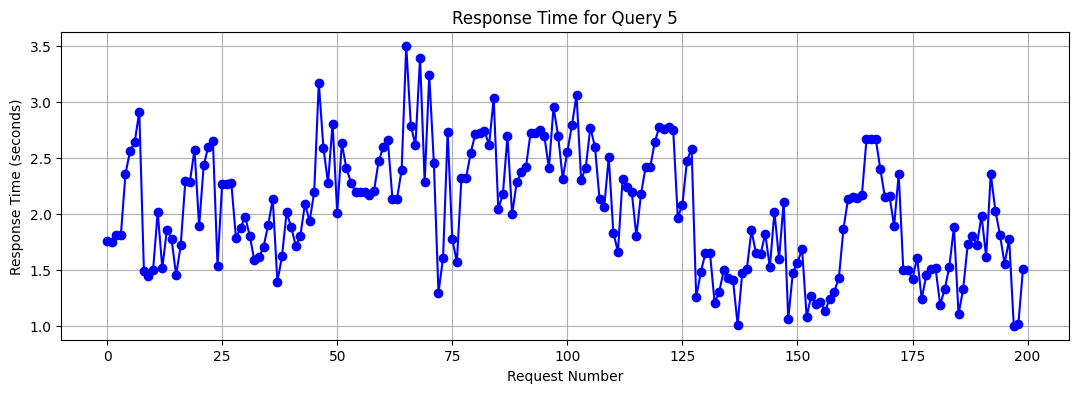

Average Response Time for Query 5: 2.04 seconds



In [28]:
if __name__ == "__main__":
    benchmark()

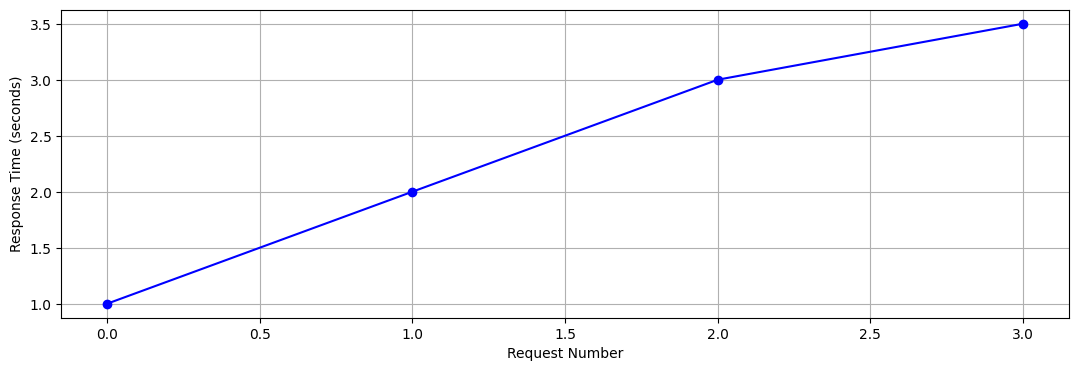

In [29]:
plt.figure(figsize=(13, 4))
plt.plot([1,2,3,3.5], marker='o', linestyle='-', color='b')
plt.xlabel('Request Number')
plt.ylabel('Response Time (seconds)')
plt.grid(True)
plt.show()

In [30]:
curs, _ = run_query(QUERY, 0) 
for row in curs:
    print(row)

TypeError: cannot unpack non-iterable float object

In [31]:
pd.DataFrame(row)

NameError: name 'row' is not defined

In [32]:


# Configuration
PINOT_SERVER_URL = 'http://localhost:9000'  # Replace with your Pinot server URL
QUERY = """

select 
t1.idtable_sale_order_id,t2.idtable_sale_order_id,
t1.__dp_update_time,t1.__tenant_id,t1.__ts_ms,
t1.created_on 
from Table_Sale_Order t1
left join Table_Sale_Order t2
on t1.idtable_sale_order_id = t2.idtable_sale_order_id
where t1.__tenant_id = 1223
order by t1.created_on desc

"""  # Replace with your query


In [33]:

def run_query():
    try:
        start_time = time.time()
        response = requests.post(f'{PINOT_SERVER_URL}/#/query', json={"pql": QUERY})
        end_time = time.time()

        print(response.status_code)
        
        if response.status_code == 200:
            return end_time - start_time
        else:
            return end_time - start_time
    except Exception as e:
        return None


In [34]:

def benchmark():
    response_times = []

    with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        futures = [executor.submit(run_query) for _ in range(NUM_REQUESTS)]
        for future in as_completed(futures):
            response_time = future.result()
            if response_time is not None:
                response_times.append(response_time)

    # Plotting the results
    plt.figure(figsize=(14, 4))
    plt.plot(response_times, marker='o', linestyle='-', color='b')
    plt.xlabel('Request Number')
    plt.ylabel('Response Time (seconds)')
    plt.title('Response Time for Each Query Request')
    # plt.title('NUM THREADS - 8, NUM_REQUESTS - 400')
    plt.grid(True)
    plt.show()

405405
405
405
405

405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405
405


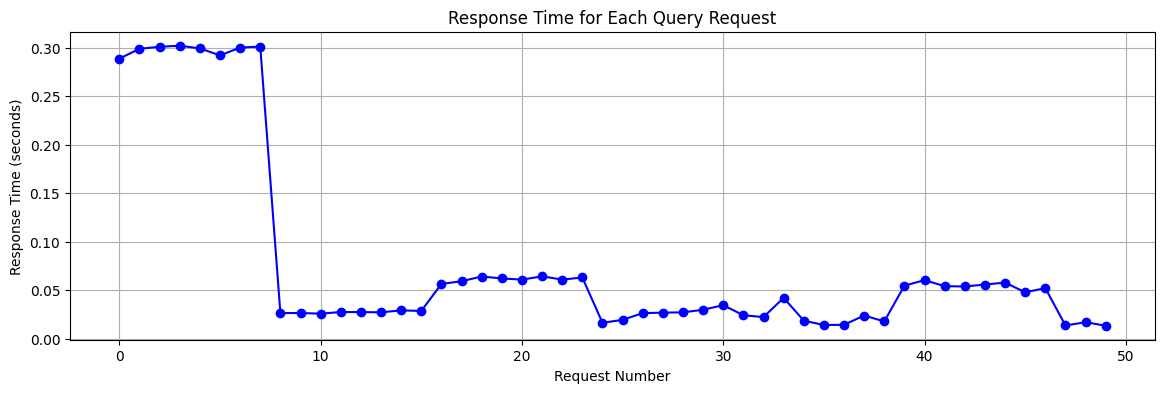

In [35]:

NUM_REQUESTS = 50  # Number of concurrent requests
NUM_THREADS = 8  # Number of concurrent threads

if __name__ == "__main__":
    benchmark()
